Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


# Lab 2: ES

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The goal of the game is to **avoid** taking the last object.

* Task2.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task2.2: An agent using evolved rules using ES

## Instructions

* Create the directory `lab2` inside your personal course repository for the course 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.



In [328]:
import logging
from pprint import pprint, pformat
from collections import namedtuple
import random
import numpy as np
      
import choice

from copy import deepcopy
from copy import copy
from dataclasses import dataclass
from typing import Callable
from matplotlib import pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm
import sys
logging.basicConfig(
    format="[%(asctime)s] %(levelname)s: %(message)s",
    datefmt="%H:%M:%S",
    level=logging.INFO,
)


## The *Nim* and *Nimply* classes

In [329]:
Nimply = namedtuple("Nimply", "row, num_objects")



In [330]:
class Nim:
    def __init__(self, num_rows: int, k: int = sys.maxsize) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)
    

    @rows.setter
    def rows(self, new_rows):
            self._rows = list(new_rows)


    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects


##  K VERSION ENEMY STRATEGY


In [331]:

#K ---------Version
def nim_sum(state: Nim) -> int:
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])
    xor = tmp.sum(axis=0) % 2
    return int("".join(str(_) for _ in xor), base=2)

def gabriele_k(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1,min(c+1,state._k+1))]
    
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))


def pure_random_k(state: Nim) -> Nimply:
    """A completely random move"""
    row = random.choice([r for r, c in enumerate(state.rows) if (c > 0)])
    num_objects = random.randint(1, min(state.rows[row],state._k))
    return Nimply(row, num_objects)

def analize_k(raw: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = dict()
    for ply in (Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1,min(c+1,raw._k+1))):
        tmp = deepcopy(raw)
        tmp.nimming(ply)
        cooked["possible_moves"][ply] = nim_sum(tmp)
    return cooked


def optimal_k(state: Nim) -> Nimply:
    analysis = analize_k(state)
    logging.debug(f"analysis:\n{pformat(analysis)}") 
    spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0]
    #best_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns == 0]
    if not spicy_moves:
       spicy_moves = list(analysis["possible_moves"].keys())
    #if not best_moves:
    #    best_moves = list(analysis["possible_moves"].keys())
   # if (best_moves):
    ply=random.choice(spicy_moves)
  #  else:
  #      ply = random.choice(spicy_moves)
    return ply

#!!! SPIEGARE

def very_optimal_k(state: Nim) -> Nimply:
    analysis = analize_k(state)
    
    #logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = None
    count_1=0
    index_row=-1
    row_value=0
    
    
    for index,value in enumerate(state.rows):
     if(value)>1:                                                               
         count_1+=1                                                             
         index_row=index                                                           #   (X,#indiffernte,xor=0)
         row_value=value          # (#numerorighe>1,numerorighe>0,xor)                (1, #dispari,indifferente)
                                                                                      
                               #(0,xor=-1) vincente      (3,-5)  (4,-5) best   
    if(count_1>1):   # (1,xor=0) (2, xor=0) # (1,xor=1)    vincente      valori maggiori di uno
                     
        spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns == 0]
    
        if not spicy_moves:
            spicy_moves = list(analysis["possible_moves"].keys())
        ply=random.choice(spicy_moves)
        return ply
    if(count_1==1):# only 1 row with more than 1 object    ->   the goals is to keep odd active rows
     
        num_active_rows = sum(o > 0 for o in state.rows)
       # print(num_active_rows)
        #print(state.rows)
       
        if(num_active_rows%2!=0): #if even take all the object in that row
           # print(fitness(state,Nimply(index_row,row_value-1)))
            return Nimply(index_row,min(state._k,row_value-1))
        else:#leave only 1 object in that row
    
          return  Nimply(index_row,min(state._k,row_value))


   
    spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0]
     
    if not spicy_moves:
       spicy_moves = list(analysis["possible_moves"].keys())
   
    ply = random.choice(spicy_moves)
    return ply


## Evolutionary 


In [332]:
@dataclass
class Weights:
    rules: list(tuple[float,Callable])= None



    def add_rule(self, weight, rule_function):
        """Add a rule to the weights."""
        if self.rules is None:
            self.rules = []
        rule = (weight, rule_function)
        self.rules.append(rule)
    
    
    def mutate_weights(self,tweaks):
        """Add a vector to all existing weights."""
      
        if self.rules is not None and len(tweaks) == len(self.rules):
            self.rules = [(weight + tweaks[i]* np.random.choice([-1, 1]), rule_function) for i, (weight, rule_function) in enumerate(self.rules)]
        
    
λ = 5
o = 0.1
k=2


## OUR STRATEGY

In [333]:
### RULE ABOUT ODD PILES ###

def calculate_smoothness(array):
    differences = np.diff(array)
    smoothness = np.std(differences)
    return smoothness
def possible_moves(raw: Nim):
    return [Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1,min(c+1,raw._k+1))]

def analize_odd_piles(raw: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = dict()
    for ply in (Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1,min(c+1,raw._k+1))):
        tmp = deepcopy(raw)
        tmp.nimming(ply)
        num_odd_piles = np.sum([el>0 for el in tmp._rows]) % 2  # il risultato sarà 0 o 1
        tmp_smoothness = -calculate_smoothness(tmp._rows) #più è piccolo il valore, e più l'array è smooth (visto che devo prendere il max, allora metto un meno davanti)
        cooked["possible_moves"][ply] = (num_odd_piles, tmp_smoothness) # calcolo quante pile dispari ci sono per ogni mossa
    return cooked
##RULE_1
def final_move(state: Nim):
        count_1=0
        
        for index,value in enumerate(state.rows):
            if(value)>1:                                                               
                count_1+=1                                                             
                index_row=index                                                           #   (X,#indiffernte,xor=0)
                row_value=value          # (#numerorighe>1,numerorighe>0,xor)                (1, #dispari,indifferente)
                                                                                            
                                    #(0,xor=-1) vincente      (3,-5)  (4,-5) best  
        if(count_1==1):# only 1 row with more than 1 object    ->   the goals is to keep odd active rows
            
            num_active_rows = sum(o > 0 for o in state.rows)
            # print(num_active_rows)
                #print(state.rows)
            
            if(num_active_rows%2!=0): #if even take all the object in that row
                # print(fitness(state,Nimply(index_row,row_value-1)))
                    if (row_value-1<=k):
                        return Nimply(index_row,min(state._k,row_value-1))
            else:#leave only 1 object in that row
                    if(row_value<=k):
                        return  Nimply(index_row,min(state._k,row_value))
            return None


##RULE_2
def odd_piles_strategy(state: Nim) -> Nimply:
    analysis = analize_odd_piles(state)
    # facilito mosse che portano ad avere righe dispari e piles più omogenei possibili
    spicy_move = max([(ply,to_evaluate) for ply,to_evaluate in analysis["possible_moves"].items()], key = lambda x: x[1])
    return spicy_move[0]

### END ODD PILES RULE ###

## ODD-EVEN RULE##
##RULE_3
def odd_even(state: Nim) -> Nimply:
    analysis = possible_moves(state)
    num_odd_piles = np.sum([el>0 for el in state._rows]) % 2  # il risultato sarà 0 o 1
    if num_odd_piles:
        myvett = [move for move in analysis if (move[1]%2)]
        if len(myvett) != 0:
            return random.choice(myvett)
        return None 
    else:
       # torna mosse con numbocjet_pari
        myvett = [move for move in analysis if not(move[1]%2)]
        if len(myvett) != 0:
            return random.choice(myvett)
        return None 

### END ODD-EVEN RULE ###

### MIRROR STRATEGY ###
##RULE_4
def mirror(state: Nim, last_ply: Nimply):
    analysis = analize_k(state)
    tot_objects = sum([i * 2 + 1 for i in range(len(state._rows))])
    left_objects = sum(state._rows)
    if last_ply:
        # mirror every move, until only a bunch of elements are left
        if left_objects >= tot_objects*0.8 and last_ply in analysis["possible_moves"]:
            #check if the strategy is suitable for the number of objects I have
            return last_ply
    return None

### END MIRROR STRATEGY ###include

In [334]:
def choose_py(weights: Weights,lastply,state: Nim):                                          
                                                             
    result_sum_dict = {}                                                               
    # Iterate over each rule in the Weights object
    for weight, rule_function in weights.rules:
        # Call the rule function with an example Nim instance
        if rule_function.__name__ == "mirror":
            move=rule_function(state,lastply)
        else:
            move = rule_function(state)
        if(move):#if move is a numply add in dictionary
            if move in result_sum_dict:
                result_sum_dict[move] = result_sum_dict.get(move) + weight
            # Update the sum of weights in the dictionary#
            else:
                result_sum_dict[move] = weight
            

        
    max_result = max(result_sum_dict, key=result_sum_dict.get) #risultato
    return max_result


def games(weights):
    won=0
    player=1;
    
    enemy_strategy=[pure_random_k,gabriele_k,optimal_k,very_optimal_k]


    tot_enemy=len(enemy_strategy)
    tot_games=tot_enemy*5
    e_strategy = enemy_strategy[tot_games%(int(tot_games/tot_enemy))]# - > NImsum non è golden rule
    for m in range (tot_games):
      
        nim = Nim(5)  
        player = (player + 1) % 2   # switch starting player every match
        lastply=None
        while nim:
            if(player==0): #our turn
             
             nim.nimming(choose_py(weights,lastply,nim))

            if(player==1): #enemy turn
             
             ply = e_strategy(nim)
             lastply=ply
             nim.nimming(ply)
        
        
            player = 1 - player
        if player == 0:
            won += 1
    return won/tot_games*100


def mutate(weight: Weights):
   
        
    
    tweaks=np.random.normal(loc=0, scale=o, size=(λ,len(weight.rules)))
    #tweaks = np.random.uniform(low=-1.0, high=+1.0, size=(λ, len(weight.rules))) plus negative version

    offspring=[]
    for tweak in tweaks:
         
         tmp=deepcopy(weight)
         
         tmp.mutate_weights(tweak)
         
         offspring.append(tmp)
         
    return offspring

[00:54:40] INFO: Best solution: 95.0->Weights(rules=[(-0.1985591125704167, <function odd_piles_strategy at 0x000001F526507CE0>), (-0.5903240587289742, <function odd_even at 0x000001F526507740>), (0.6173004009710118, <function mirror at 0x000001F526507880>), (0.4037644513627282, <function final_move at 0x000001F526505760>)])


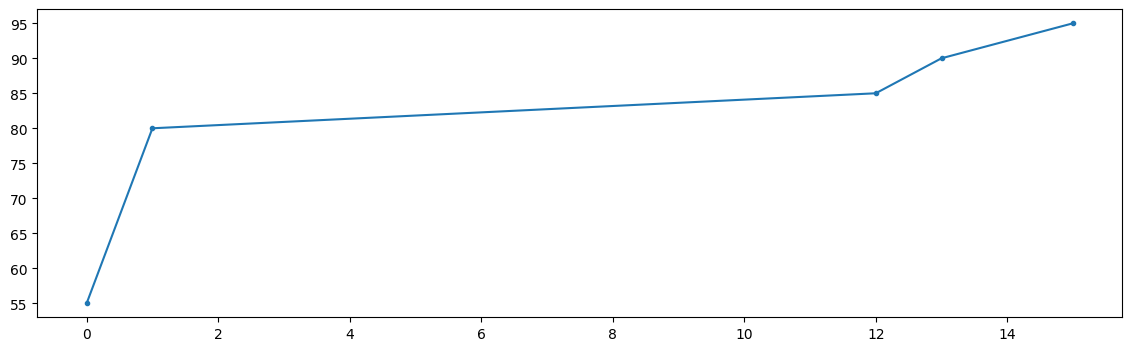

In [335]:
w=Weights()
w.add_rule(0,odd_piles_strategy)                  
w.add_rule(0,odd_even)
w.add_rule(0,mirror)
w.add_rule(0,final_move)
initial_weights = np.random.normal(loc=0, scale=0.1, size=(len(w.rules)))
w.mutate_weights(initial_weights)
solution=w
best_solution=deepcopy(w)
fitness_best=games(best_solution)

history=list()
for n in range(20):
   
  offspring = (mutate(solution))
  evals=[]
  [evals.append(games(x_offspring)) for  x_offspring in  offspring]
  solution=offspring[np.argmax(evals)]
  fitness_solution=games(solution) #max evals
  if fitness_best < fitness_solution:
    best_solution=deepcopy(solution)
    fitness_best=fitness_solution
    history.append((n, fitness_solution))
  

logging.info(f"Best solution: {fitness_best}->{best_solution}")
history = np.array(history)
plt.figure(figsize=(14, 4))
plt.plot(history[:, 0], history[:, 1], marker=".")

 